In [2]:
!pip install -q -U mxnet-cu101mkl==1.6.0.post0 
!pip install d2l==0.14.0

In [3]:
!git clone "https://github.com/Ravikiran-Bhonagiri/aws-machine-learning-university-accelerated-cv.git"

Cloning into 'aws-machine-learning-university-accelerated-cv'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2962 (delta 4), reused 6 (delta 1), pack-reused 2948
Receiving objects: 100% (2962/2962), 180.36 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Checking out files: 100% (3043/3043), done.


In [4]:
import os
from d2l import mxnet as d2l
import mxnet as mx
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import numpy as np

In [5]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

In [6]:
batch_size = 16

path = '/content/aws-machine-learning-university-accelerated-cv/data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

test_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

In [7]:
def FineTuneAlexnet(classes, ctx):
    '''
    classes: number of the output classes 
    ctx: training context (CPU or GPU)
    '''
    finetune_net = gluon.model_zoo.vision.alexnet(classes=classes, pretrained=False, ctx=ctx)
    finetune_net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    pretrained_net = gluon.model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    finetune_net.features = pretrained_net.features
    
    return finetune_net

In [8]:
ctx = d2l.try_gpu() # Create neural net on CPU or GPU depending on your training instances
num_outputs = 6  # 6 output classes
net = FineTuneAlexnet(num_outputs, ctx)
net

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), Activation(relu))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (8): Flatten
    (9): Dense(9216 -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes

In [9]:
learning_rate = 0.001
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

In [10]:
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [11]:
def finetune_accuracy(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) == label.astype('float32')).mean()

In [13]:
epochs = 10

for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy_loss(output, label)
        loss.backward()
        train_acc += finetune_accuracy(output, label)
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += finetune_accuracy(output, label)
        val_loss += softmax_cross_entropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))


Epoch 0: train loss 1.419, train acc 0.490, val loss 0.782, val acc 0.719
Epoch 1: train loss 0.845, train acc 0.706, val loss 0.580, val acc 0.849
Epoch 2: train loss 0.661, train acc 0.765, val loss 0.520, val acc 0.865
Epoch 3: train loss 0.546, train acc 0.797, val loss 0.491, val acc 0.870
Epoch 4: train loss 0.504, train acc 0.829, val loss 0.466, val acc 0.880
Epoch 5: train loss 0.438, train acc 0.845, val loss 0.488, val acc 0.859
Epoch 6: train loss 0.387, train acc 0.866, val loss 0.449, val acc 0.880
Epoch 7: train loss 0.371, train acc 0.868, val loss 0.440, val acc 0.865
Epoch 8: train loss 0.337, train acc 0.878, val loss 0.436, val acc 0.885
Epoch 9: train loss 0.306, train acc 0.896, val loss 0.459, val acc 0.865


In [14]:
net.save_parameters("my_model")

In [15]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


[0. 2. 4. 0. 3. 4. 0. 0. 0. 1. 3. 5. 0. 3. 2. 2.]
<NDArray 16 @gpu(0)>


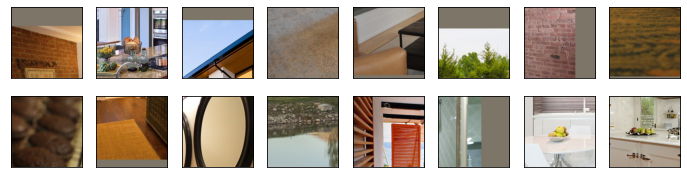

In [16]:
random_test_sample = gluon.data.DataLoader(gluon.data.vision.ImageFolderDataset(test_path),
                                    batch_size=2*8, shuffle=True)

for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.as_in_context(ctx)
    pred = net(transform_test(data))
    print(pred.argmax(axis=1))
    break